# Введение

Перед нами, как перед аналитиком стартапа по продаже продуктов питания, поставлена задача изучить поведение покупателей на протяжении всего процесса покупки и найти возможные слабые места. Для этого нужно будет изучить весь процесс, разделить его на стадии, посмотреть, в каких точках перехода могут возникать проблемы.

Будет необходимо изучить результаты А/А/В теста, связанного с изменением восприятия новых текстовых шрифтов на сайте, для чего сначала необходимо провести А/А тест для сравнения контрольных групп, и только затем прнимать решение о дальнейшем эксперименте.

Затем нужно будет систематизировать данные и изложить выводы.

# Подготовка данных

In [1]:
# импортируем рабочие модули
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

In [2]:
# зададим единый размер для всех графиков
plt.rcParams['figure.figsize'] = [20, 8]

In [3]:
# импорт датасетов в рабочие фреймы, деление на столбцы
data = pd.read_csv('/datasets/logs_exp.csv', sep="\s+", engine='python')

In [4]:
# просмотр информации о таблицах, проверка на наличие дубликатов и пустот
for i in [data]:
    display(i.head(3))
    display(i.info())
    print(i.duplicated().sum(), i.isnull().sum())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

413 EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


4 столбца, 244 тыс. строк, 413 дубликатов.

Названия столбцов согласно описанию:

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [5]:
# переименование столбцов и привод к единому стилю
df = data.rename(columns={'EventName': 'event', 'DeviceIDHash': 'uid', 'EventTimestamp': 'ets', 'ExpId': 'group'})

In [6]:
# т.к. удельный вес дубликатов составляет меньше 0,01%, их можно невозбранно удалить
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [7]:
# добавление новых столбцов - столбец даты и времени, а также отдельный столбец дат
df.insert(4, "datetime", 0)
df.insert(5, "date", 0)
df.head(3)

,event,uid,ets,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,0,0
1,MainScreenAppear,7416695313311560658,1564053102,246,0,0
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,0,0


# Изучение и проверка данных

## Количество событий в логе

In [8]:
# подсчитаетм количество строк
df['uid'].count()

243713

Во фрейме насчитывается 243713 строк.

## Количество пользователей в логе

In [9]:
# подчитаем количество пользователей
df['uid'].nunique()

7551

Итого 7551 уникальный пользователь.

## Количество событий в среднем на пользователя

In [10]:
# вычисляем среднее количество событий на одного человека
print(f'В среднем на одного пользователя приходится {int(len(df) / len(df.uid.unique()))} события.')

В среднем на одного пользователя приходится 32 события.


## Временные рамки событий

In [11]:
# судя по содержанию столбца, это т.н. epoch-time, и его сначала надо будет сконвертировать
df['datetime'] = pd.to_datetime(df['ets'], unit='s')
df['datetime'].head(3)

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
Name: datetime, dtype: datetime64[ns]

In [12]:
df['datetime']

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
243708   2019-08-07 21:12:25
243709   2019-08-07 21:13:59
243710   2019-08-07 21:14:43
243711   2019-08-07 21:14:58
243712   2019-08-07 21:15:17
Name: datetime, Length: 243713, dtype: datetime64[ns]

In [13]:
# столбец dates отдельно заполним датами по дням
df['date'] = df.datetime.dt.date

In [14]:
# теперь найдём максимальную и минимальную дату, вычислим промежуток событий
df['date'].min(), df['date'].max()

(datetime.date(2019, 7, 25), datetime.date(2019, 8, 7))

In [15]:
df['datetime'].max() - df['datetime'].min()

Timedelta('13 days 16:31:41')

Самое раннее событие датируется 25 июля 2019 года, самое позднее - 7 августа того же года, временной промежуток составляет 14  дней.

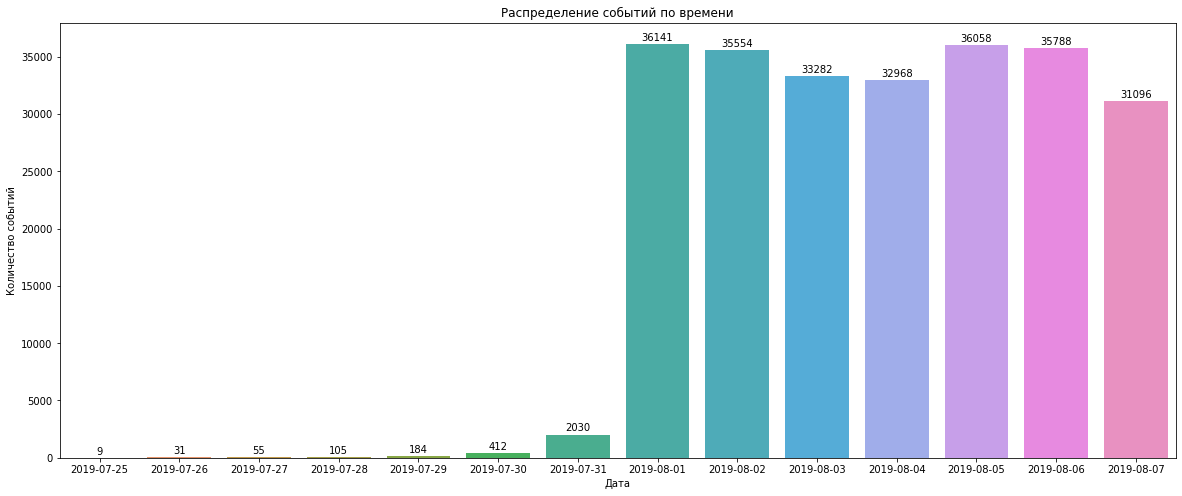

In [16]:
# Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий 
# в зависимости от времени в разрезе групп
srs = df.groupby('date')[['event']].count().reset_index()

ax = sns.barplot(x='date', y='event', data=srs)
for i, v in srs.iterrows():
       ax.text(i, v[1]+300, str(v[1]), ha='center')
plt.title('Распределение событий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

Как видно из графика, до 31 июля количество событий околонулевое, и только с 1 августа они начинают расти до ощутимых значений.
Можно предположить, что магазин работал в тестовом режиме и/или не была проведена рекламная кампания. Для ясности лучше отфильтровать малозначимые данные.

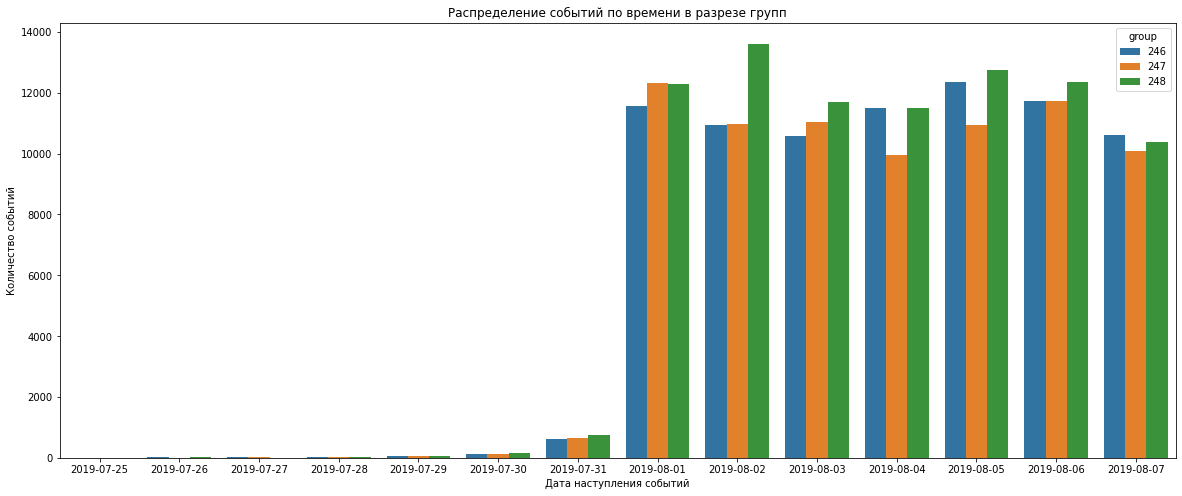

In [17]:
ax = sns.countplot(x='date', data=df, hue = 'group')
plt.title('Распределение событий по времени в разрезе групп')
plt.xlabel('Дата наступления событий')
plt.ylabel('Количество событий')
plt.show()

Групповое распределение показывает такую же картину, стабильного и нарастающего преимущества нет ни у одной из групп, обычные флуктуации.

In [18]:
# отфильтруем фрейм по дате с 1 по 7 августа
df_filt = df.query('date >= datetime(2019, 8, 1).date()')
# посчитаем события до и после фильтрации
events_stock = len(df['event'])
events_filt = len(df_filt['event'])
# и количество пользователей
users_stock = df['uid'].nunique()
users_filt = df_filt['uid'].nunique()

In [19]:
# вывод абсолютной и относительной разницы по событиям и пользователям
print('Потеряно событий: до - {}, после - {}. Разница составляет: {} случаев или {}%'.format(events_stock, events_filt,
                                                                        events_stock - events_filt,
                                                                        round(100-events_filt/events_stock*100, 2)))
print('Потеряно пользователей: до - {}, после - {}. Разница составляет: {} человек или {}%'.format(users_stock, users_filt,
                                                                        users_stock - users_filt,
                                                                        round(100-users_filt/users_stock*100, 2)))


Потеряно событий: до - 243713, после - 240887. Разница составляет: 2826 случаев или 1.16%
Потеряно пользователей: до - 7551, после - 7534. Разница составляет: 17 человек или 0.23%


Соотвественно, за первую неделю отсеялось чуть больше 1% данных, и ими можно спокойно пренебречь, соотношение численности групп также не показывает значимых перекосов.

# Изучение воронки событий

## Посмотрим, какие события есть в логах, как часто они встречаются, отсортируем события по частоте

In [20]:
# просмотр событий
print(df_filt['event'].unique())

['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful']


В категории событий есть 5 записей:

- Tutorial - введение, обучение
- MainScreenAppear - просмотр главной страницы
- OffersScreenAppear - просмотр страницы предложений
- CartScreenAppear - просмотр корзины
- PaymentScreenSuccessful - подтверждение успешной оплаты

Все события после введения выстроены в единую последовательность для совершения покупок, введение может быть как обязательным, так и пропускаемым - из характеристик таблицы это сказать нельзя.

## Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие

In [21]:
# сгруппируем уникальных пользователей по событиям
event_users = df_filt.groupby('event').agg({'uid':'nunique'}).reset_index()
event_users.set_axis(['event', 'users_count'], axis='columns', inplace=True)

# укажем долю уникальных пользователей по событиям
event_users['%'] = event_users.users_count / df_filt['uid'].nunique()
event_users = event_users.sort_values('users_count', ascending=False).reset_index(drop=True)

# построим воронку продаж
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'users_count'] /  (event_users.loc[i-1, 'users_count'])
    
event_users    

,event,users_count,%,funnel
0,MainScreenAppear,7419,0.984736,1.000000
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777
4,Tutorial,840,0.111495,1.000000


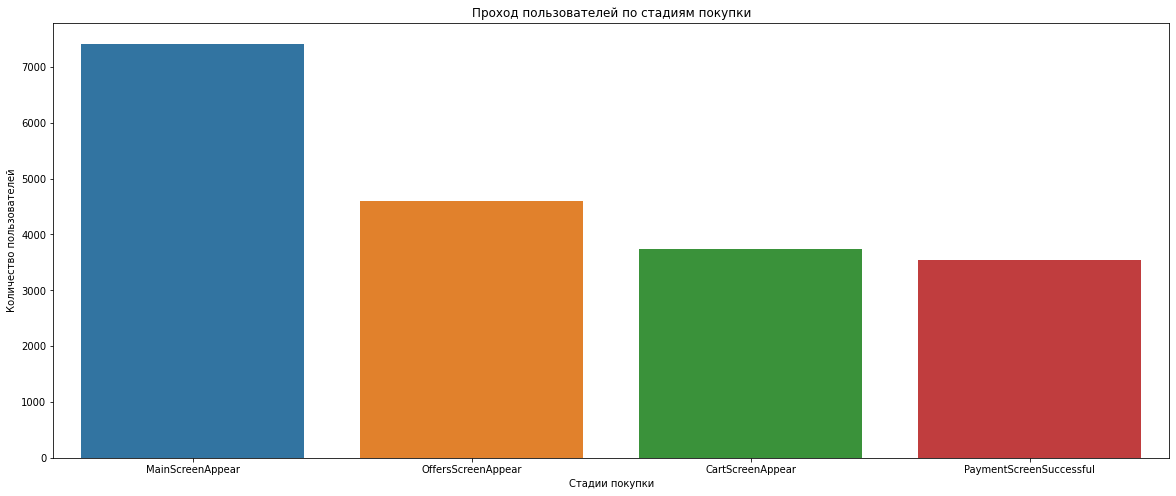

In [22]:
sns.barplot(data=event_users.loc[0:3], x='event', y='users_count')
plt.title('Проход пользователей по стадиям покупки')
plt.xlabel('Стадии покупки')
plt.ylabel('Количество пользователей')
plt.show()

События распределены нормально и последовательно, до страницы оплаты доходит примерно половина всех посетителей. Исходя из доли "Tutorial" теперь можно сказать, что оно является необязательным, а его небольшая доля в количестве запросов показывает, что дизайн магазина с точки зрения "user-friendly" положителен.

На главную страницу зашли 7419 пользователей, в каталог - 4593, в корзину - 3734, оплатили - 3539, обучение же закончили всего 840 пользователей.

Наибольшая часть пользователей отсеивается на стадии перехода с главной страницы в каталог - отпадает примерно 39%.

От входа до оплаты доходит примерно 47% пользователей.

# Результаты эксперимента

In [23]:
# рассмотрим количество пользователей в каждой экспериментальной группе
print(df_filt.groupby('group')['uid'].nunique())

group
246    2484
247    2513
248    2537
Name: uid, dtype: int64


В контрольной группе "А1" 2484 пользователя, в "А2" - 2513, в тестовой "В" - 2537.

Критерии успешного A/A теста:
- Разброс количества пользователей в группах различается не более чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же объекте подсчёта;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп пользователь остаётся в этой группе до конца теста.

In [24]:
# есть 2 контрольные группы, проверим их на значимую разницу
for i in range(0, 3):
    test_groups = [246, 247, 248, 246]
    print(f'Разница между группой {test_groups[i]} и {test_groups[i+1]} составляет {1 - df_filt.query("group == @test_groups[@i]")["uid"].nunique() / df_filt.query("group == @test_groups[@i+1]")["uid"].nunique():.2%}')

Разница между группой 246 и 247 составляет 1.15%
Разница между группой 247 и 248 составляет 0.95%
Разница между группой 248 и 246 составляет -2.13%


Разница между контрольными группами "А1" и "А2" составляет более 1%, точнее - 1,15% что немного превышает стапогрешность.
Разница между "А1" и "В" составляет 2,13%, что также превышает статпогрешность.
Разница между "А2" и "В" составляет 0,95%, что не превышает статпогрешности.

In [25]:
# поиск uid, попавших одновременно в разные группы
len(df_filt.groupby('uid')['group'].nunique().reset_index().query('group > 1'))

0

Среди пользователей нет попавших сразу в разные группы.

Теперь необходимо проверить различие ключевых метрик. Для каждого события нужно подсчитать, какая доля пользователей в каждой группе его совершила, и проверить, является ли отличие между группами статистически достоверным.

In [26]:
events_groups = df_filt.pivot_table(index='event', columns='group', values='uid', aggfunc='nunique', margins=True).reset_index().sort_values('All', ascending=False).reset_index(drop=True)
events_groups = events_groups.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
events_groups

group,event,246,247,248,All
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,Tutorial,278,283,279,840
5,All,2484,2513,2537,7534


In [27]:
def diff(positive1, positive2, test1, test2):
    # соотношение успехов в первой группе:
    p1 = positive1/test1
    # соотношение успехов во второй группе:
    p2 = positive2/test2
    # соотношение успехов в комбинированном датасете:
    p_combined = (positive1 + positive2) / (test1 + test2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / (p_combined * (1 - p_combined) * (1/test1 + 1/test2)) ** 0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [28]:
#  для записи результатов
groups_stats = pd.DataFrame({'events' : ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
                             '246-247' : [0, 0, 0, 0, 0],
                             '247-248' : [0, 0, 0, 0, 0],
                             '248-246' : [0, 0, 0, 0, 0]})

# цикл по всем событиям и комбинациям
# для каждой пары групп и для каждого события посчитаем вероятности получения таких различий
for i in range(0, 5):
    for j in range(1, 4):
        # для группы 248 парной должна побывать и 246
        k = j + 1 if j < 3 else 1
        # общее количество пользователей в группе в пятой строке All
        groups_stats.iloc[i, j] = diff(events_groups.iloc[i, j], 
                                              events_groups.iloc[i, k], 
                                              events_groups.iloc[5, j], 
                                              events_groups.iloc[5, k])

# итог c подсветкой самого низкого результата
groups_stats.iloc[:, [0, 1]].style.highlight_min(color='yellow', axis=None)

,events,246-247
0,MainScreenAppear,0.757060
1,OffersScreenAppear,0.248095
2,CartScreenAppear,0.228834
3,PaymentScreenSuccessful,0.114567
4,Tutorial,0.937700


Для всех событий разница в пропорциях недостаточна, чтобы говорить о статистически значимом различии, т.е. между группами 246 и 247 разницы нет, несмотря на исходную разницу в численности.

## Проведение А/B теста

Принимая во внимание ранее рассчитаные данные для групп А1, А2 и В, необходимо теперь посчитать из различие попарно. Выдвинем соответствующие гипотезы:

Гипотеза H0: между долями групп нет значимой разницы; 
Гипотеза H1: между долями групп есть значимая разница.

In [29]:
 groups_stats.iloc[:, [0, 2, 3]].style.highlight_min(color='yellow', axis=0)

,events,247-248,248-246
0,MainScreenAppear,0.458705,0.294972
1,OffersScreenAppear,0.919782,0.208362
2,CartScreenAppear,0.578620,0.078429
3,PaymentScreenSuccessful,0.737342,0.212255
4,Tutorial,0.765324,0.826429


Добавим в таблицу events_group столбец для объединенной группы 246+247 и сравним ее с группой 248.

In [30]:
events_groups['246+247'] = events_groups[246] + events_groups[247]
events_groups

group,event,246,247,248,All,246+247
0,MainScreenAppear,2450,2476,2493,7419,4926
1,OffersScreenAppear,1542,1520,1531,4593,3062
2,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,Tutorial,278,283,279,840,561
5,All,2484,2513,2537,7534,4997


In [31]:
# создаем столбец со статистическими показателяим
groups_stats['246+247-248'] = 1

for i in range(0, 5):
    groups_stats.iloc[i, 4] = diff(events_groups.iloc[i, 3], 
                                        events_groups.iloc[i, 5], 
                                        events_groups.iloc[5, 3], 
                                        events_groups.iloc[5, 5])

In [32]:
groups_stats.style.highlight_min(color='yellow', axis=0)

,events,246-247,247-248,248-246,246+247-248
0,MainScreenAppear,0.757060,0.458705,0.294972,0.294245
1,OffersScreenAppear,0.248095,0.919782,0.208362,0.434255
2,CartScreenAppear,0.228834,0.578620,0.078429,0.181759
3,PaymentScreenSuccessful,0.114567,0.737342,0.212255,0.600429
4,Tutorial,0.937700,0.765324,0.826429,0.764862


Как видно из таблицы, для всех событий и всех пар групп p-value значительно больше 0.05 - самое низкое значение 0,078.
Следовательно, нулевую гипотезу не удалось отвергнуть, и шрифт не влияет на взаимодействие пользователя с приложением.
Было проверено 16 гипотез, т.е. группы 246, 247, 248 перекрёстно плюс совмещённая контрольная группа (246+247) с тестовой.

При коррекции уровня значимости по методу Бонферрони до оптимального он составит 0.05/16 или 0.03, что также меньше любого p-value из таблицы результатов.

# Выводы

В ходе исследования были проверены данные о работе стартапа - магазина по продаже продуктов питания. Данные были получены 
в ходе проведения эксперимента. Нулевой гипотезой было предположение, что выбранный дизайнерами шрифт не влияет 
на взаимодействие пользователей с приложением. Отвергнуть эту гипотезу не удалось, по-видимому, шрифт действительно не влияет 
на пользователей, либо новый шрифт так же удобен и читаем, как старый. 
Наибольший скачок в воронке наблюдается между начальной страницей приложения и каталогом - этот этап не проходят примерно 
39% пользователей. Предположительно, здесь может быть или неправильная компоновка страницы - трудно найти иконку каталога, 
или неактивна внешняя ссылка для перехода, или по какой-то поведенческой причине пользователь меняет своём мнение - или
обнаруживает, что характер сайта не соотвествует его желаниям (вместо фермерских продуктов обычные, например), или выскакивает
баннер на всю страницу с предложением пройти тот самый туториал, или что-то подобное.